# Main PyEPO
This notebook uses our classes in close connection with the PyEPO library and follows their tutorial in creating a shortest path optnet.

In [1]:
# Add the parent directory to the path
import sys, os
sys.path.insert(0, os.path.abspath(".."))

## Optimizers
We start with defining an optimization problem with an optimizer.

In [2]:
# Import numpy and ShortestPathGrb class
import numpy as np
from src.models.ShortestPathGrb import shortestPathGrb

In [3]:
# Define grid size
m, n = 5, 5

# Create a grid instance
opt_model = shortestPathGrb()

Restricted license - for non-production use only - expires 2026-11-23


In [4]:
# Define random cost
cost = np.random.rand(opt_model.num_cost)

# Set the cost for the grid (Optionally specify the source and target nodes)
opt_model.setObj(cost)

In [5]:
# Solve shortest path problem
path, obj = opt_model.solve()
for i, e in enumerate(opt_model.arcs):
    if path[i] > 1e-3:
        print(e)
# print(ShortestPathGrid.one_hot_to_arcs(opt_model, path))

# # Visualize the grid with the shortest path highlighted
# opt_model.visualize(color_edges=path)

(0, 5)
(5, 6)
(6, 7)
(7, 12)
(12, 13)
(13, 18)
(18, 19)
(19, 24)


## Datasets
We use PyEPO to generate data for the shortest path problem and use its ``optDataset`` class for data storage and loading.

In [6]:
import pyepo

# Set parameters for data generation
num_train_data = 1000 # number of training data
num_test_data = 1000 # number of test data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width

# Generate data for shortest path problem
feats, costs = pyepo.data.shortestpath.genData(
    num_train_data+num_test_data, 
    num_feat, 
    (m,n), 
    deg=deg, 
    noise_width=e, 
    seed=135
)

In [7]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(
    feats, 
    costs, 
    test_size=num_test_data, 
    random_state=42
)

In [8]:
# Create datasets for training and testing
dataset_train = pyepo.data.dataset.optDataset(opt_model, x_train, c_train)
dataset_test = pyepo.data.dataset.optDataset(opt_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3853.58it/s]

Optimizing for optDataset...



100%|██████████| 1000/1000 [00:00<00:00, 3922.17it/s]


In [9]:
# Wrap dataset into PyTorch DataLoader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Training and Testing
We will now create a predictive model. Then we train and test it with the artificial data created in the previous section.

In [18]:
from src.models.LinearRegression import LinearRegression

# Instantiate linear regression model
model = LinearRegression(num_feat=num_feat, num_edges=opt_model.num_cost)

In [19]:
# Create an instance of the PyEPO liniear regret function
regret = pyepo.metric.regret(model, opt_model, loader_test)

In [20]:
from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    # draw plot for regret on test
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.5)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

In [21]:
# Init SPO+ loss
spop = pyepo.func.SPOPlus(opt_model, processes=2)

# Init optimizer
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=1e-2)

Num of cores: 2


In [ ]:
from src.models.trainer import Trainer

# Create a trainer instance
trainer = Trainer(pred_model=model, opt_model=opt_model, optimizer=optimizer, loss_fn=spop)

train_loss_log, train_regret_log, test_loss_log, test_regret_log = trainer.fit(loader_train, loader_test)

Epoch 00 | Train Loss: 3.9182 | Train Regret: 0.0941 | Test Loss: 1.7384 | Test Regret: 0.0884
Epoch 01 | Train Loss: 1.5197 | Train Regret: 0.0762 | Test Loss: 1.4130 | Test Regret: 0.0746
Epoch 02 | Train Loss: 1.3740 | Train Regret: 0.0769 | Test Loss: 1.3657 | Test Regret: 0.0744
Epoch 03 | Train Loss: 1.3414 | Train Regret: 0.0742 | Test Loss: 1.3409 | Test Regret: 0.0751
Epoch 04 | Train Loss: 1.3177 | Train Regret: 0.0764 | Test Loss: 1.3351 | Test Regret: 0.0767
Epoch 05 | Train Loss: 1.3206 | Train Regret: 0.0752 | Test Loss: 1.3591 | Test Regret: 0.0763
Epoch 06 | Train Loss: 1.3297 | Train Regret: 0.0733 | Test Loss: 1.3487 | Test Regret: 0.0745
Epoch 07 | Train Loss: 1.3214 | Train Regret: 0.0783 | Test Loss: 1.3791 | Test Regret: 0.0808
Epoch 08 | Train Loss: 1.3447 | Train Regret: 0.0764 | Test Loss: 1.3408 | Test Regret: 0.0740
Epoch 09 | Train Loss: 1.2979 | Train Regret: 0.0773 | Test Loss: 1.3552 | Test Regret: 0.0760


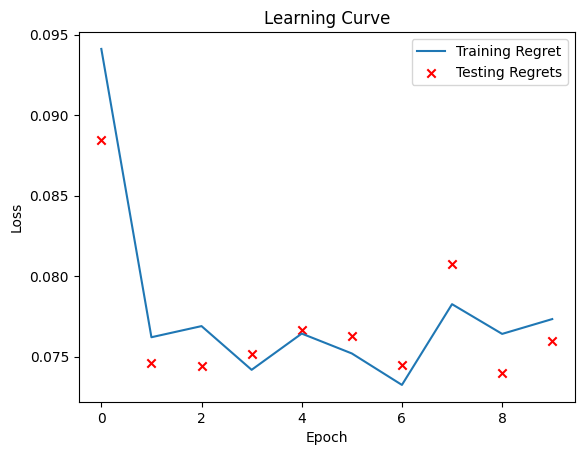

In [26]:
import matplotlib.pyplot as plt

# Plot learning curve and optionally test loss
plt.plot(train_regret_log, label='Training Regret')
if test_regret_log is not None:
    plt.scatter(np.arange(len(test_regret_log))*trainer.n_epochs, test_regret_log, marker='x', color='red', label='Testing Regrets')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()